In [122]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [123]:
canonical_file="../dataset/canonical_trainset.csv"

In [124]:
canonical_smiles_df=pd.read_csv(canonical_file)

In [125]:
canonical_smiles_df.head()

,SMILES,Label
0,CN(C)C(=N)N=C(N)N,Negative
1,COC(=O)C=CC(=O)O,Negative
2,O=C(O)C=Cc1ccccc1,Negative
3,Cc1ccc(C(C)C)cc1O,Negative
4,COc1ccc(C(=O)O)cc1,Negative


# find unique elements and their number within all SMILES

In [126]:
def find_unique_elements_and_atomic_numbers(smiles_series):
    atomic_numbers = {}

    for smiles in smiles_series:
        mol = Chem.MolFromSmiles(smiles)
        if not mol: 
            continue
        
        mol_with_h = Chem.AddHs(mol)
        
        for atom in mol_with_h.GetAtoms():
            element = atom.GetSymbol()
            atomic_numbers[element] = atom.GetAtomicNum()

    return atomic_numbers


# create one hot

In [127]:
def one_hot_encode(val, categories):
    return [int(val == category) for category in categories]

# get all unique atom number 

In [128]:
atomic_numbers = find_unique_elements_and_atomic_numbers(canonical_smiles_df["SMILES"])
atom_number = list(atomic_numbers.values())

# get atom features

In [129]:
def get_atom_features(atom):
    atom_type = atom.GetAtomicNum()
    atom_degree = atom.GetDegree()
    atom_implicit_valence = atom.GetImplicitValence()
    atom_aromatic = int(atom.GetIsAromatic())
    atom_hybridization = atom.GetHybridization()
    total_num_hs = atom.GetTotalNumHs()   
    
    atom_type_encoded = one_hot_encode(atom_type,atom_number)  
    hybridization_types = [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3]
    hybridization_encoded = one_hot_encode(atom_hybridization, hybridization_types)
    
    return np.array([atom_degree, atom_implicit_valence, atom_aromatic, total_num_hs] + atom_type_encoded + hybridization_encoded, dtype=np.float32)


# get bond features

In [130]:
def get_bond_features(bond):
    bond_type = bond.GetBondType()
    bond_conjugated = int(bond.GetIsConjugated())
    bond_in_ring = int(bond.IsInRing())
    
    bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    bond_type_encoded = one_hot_encode(bond_type, bond_types)
    
    return np.array([bond_conjugated, bond_in_ring] + bond_type_encoded, dtype=np.float32)

# mian function

In [131]:
def preprocess_smiles(smiles_list):
    nodes_features = []
    edges_features = []
    adjacency_matrices = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            continue
        
        mol = Chem.AddHs(mol)  
        
        atoms_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
        nodes_features.append(np.array(atoms_features))
        
        num_atoms = len(atoms_features)
        
        # get adjacency matrix
        adjacency_matrix = np.zeros((num_atoms, num_atoms), dtype=np.float32)
        bonds_features = []
        
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            bond_features = get_bond_features(bond)
            bonds_features.append((start, end, bond_features))
            adjacency_matrix[start, end] = adjacency_matrix[end, start] = 1
        
        edges_features.append(np.array(bonds_features, dtype=object))
        adjacency_matrices.append(adjacency_matrix)

    return nodes_features, edges_features, adjacency_matrices

In [132]:
nodes_features, edges_features, adjacency_matrices = preprocess_smiles(canonical_smiles_df["SMILES"])

[array([[3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.],
       [3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.],
       [4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.],
       [4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.],
       [3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 

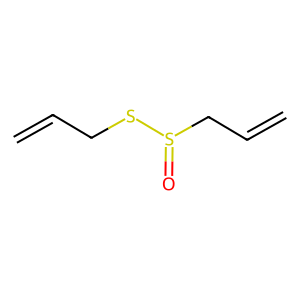

In [133]:
# test
smiles_list=["C=CCSS(=O)CC=C"]
nodes_features, edges_features, adjacency_matrices = preprocess_smiles(smiles_list)

print(nodes_features)
print(edges_features)
print(adjacency_matrices)

mol = Chem.MolFromSmiles(smiles_list[0])  
Chem.rdDepictor.Compute2DCoords(mol)
Draw.MolToImage(mol)